# COGS 118A - Project Checkpoint

# Names

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

# Abstract 
This section should be short and clearly stated. It should be a single paragraph <200 words.  It should summarize: 

- what your goal/problem is
- what the data used represents and how they are measured
- what you will be doing with the data
- how performance/success will be measured


Our goal is to build a model that accurately classfies handwritten digits. This problem is quite useful and is used in automating the process of cashing in/depositing checks. We plan to use the MNIST handwritten dataset, which holds data for more than 70,000 images. With our data, we plan to build a model using the k-NN algorithm introduced in class, and then evaluate the error through a 10x10 confusion matrix representing each digit. Since the dataset is more or less balanced across all the digits, we plan to use accuracy or f1 score as our metric. Additionally, we will be testing the model with different k values to find the optimal value.

Further, we plan to create a basic neural network using the sigmoid function as our activation layer, since it represents probability well (for each datapoint, we will find the prob. it belongs to a certain class, and then choose the max prob). We will have to one hot encode the dataset, then choose an optimizer (probably Adam since it uses adaptive learning rates), and then also a loss function (probably cross entropy). Finally, we will be able to evaluate it the model in the same way as our knn model, and compare the models.


# Background

Fill in the background and discuss the kind of prior work that has gone on in this research area here. **Use inline citation** to specify which references support which statements.  You can do that through HTML footnotes (demonstrated here). I used to reccommend Markdown footnotes (google is your friend) because they are simpler but recently I have had some problems with them working for me whereas HTML ones always work so far. So use the method that works for you, but do use inline citations.

Here is an example of inline citation. After government genocide in the 20th century, real birds were replaced with surveillance drones designed to look just like birds<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote). Use a minimum of 2 or 3 citations, but we prefer more <a name="admonish"></a>[<sup>[2]</sup>](#admonishnote). You need enough citations to fully explain and back up important facts. 

Remeber you are trying to explain why someone would want to answer your question or why your hypothesis is in the form that you've stated. 


### TODO: 


# Problem Statement

The goal of the project is to develop and compare KNN and neural network models which can both accurately classify the digits in the MNIST dataset; the project is important to the real world as these models are used in postal services, banking, and investment firms. The models will be evaluated based on their accuracy, which will be found as the percentage of correctly classified digits. In order to accurately classify these labels, we will be using stochastic gradient descent which was described in class to minimize our loss.

# Data

Our data is the MNIST dataset which can easily downloaded through tensorflow and keras, which is what we are going to use.
Each observation consists of a handwritten digit which can be from 0-9, size 28x28 pixels and 70,000 total images. Here is a link to the [dataset.](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/mnist.py)

We will need to normalize the images, meaning rescaling the pixel values so that they are all consistent. Since we are dealing with images, we can just use the pixels as our range. The max value of a pixel is 255, so if we divide each image by 255, the pixels should all be in the range of 0-1. Other than that, there isn't any special handling of the data that's necessary, because this is a widespread dataset that is commonly used. However, we can just split the data into training and testing data as shown below.


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Normalize the input images
x_train = x_train / 255.0
x_test = x_test / 255.0
# Print the shape of the training and testing sets
print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

Training set shape: (60000, 28, 28) (60000,)
Testing set shape: (10000, 28, 28) (10000,)


# Proposed Solution


Since our training data is plentiful, we will first use k-NN as our benchmark model. Our solution is to convert and normalize the images into feature vectors by flattening the image, and then creating a datastructure for all these vectors so it will be efficient to pull out the labels during the test period. Next, we will have to choose different values of k to tune the hyperparameters, and then choose the best k value based on our evaluation metrics.

Next, for our neural network, we can just use the same data from our knn model as its been preprocessed. Then, we will design the architecture of the model. We will first use adam for our optimizer as well as the sigmoid function as our activation function, since it will represent probability well. For each training point, when we pass through the activation layer we intend to return the probability it belongs to each class, and select the highest. Then, we will compare the predicted label with the true label to see if the loss function is necessary, then finally update the parameters of the model. We will try this model with multiple different parameters to select the best model.

Finally, we will compare both models and evaluate which one performs better.

# Evaluation Metrics

Propose at least one evaluation metric that can be used to quantify the performance of both the benchmark model and the solution model. The evaluation metric(s) you propose should be appropriate given the context of the data, the problem statement, and the intended solution. Describe how the evaluation metric(s) are derived and provide an example of their mathematical representations (if applicable). Complex evaluation metrics should be clearly defined and quantifiable (can be expressed in mathematical or logical terms).



#### TODO: Write about confusion matrix, precision and f1 score. we want  these 2 b.c it puts weight on the false positives. see the ethics section that i wrote.


# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



Accuracy: 0.9861111111111112


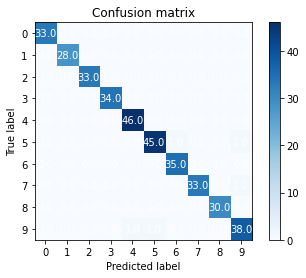

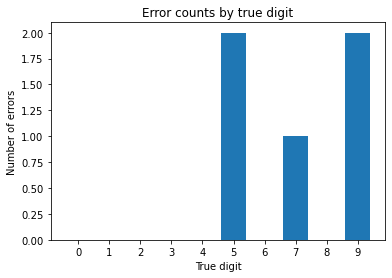

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
digits = load_digits()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# Create a k-NN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute the confusion matrix and error for each digit
conf_matrix = np.zeros((10, 10))
error_counts = np.zeros(10)
for true_label, pred_label in zip(y_test, y_pred):
    conf_matrix[true_label, pred_label] += 1
    if true_label != pred_label:
        error_counts[true_label] += 1
        
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, cmap='Blues')
# Set the axis labels and title
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion matrix')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Loop over data and annotate the matrix entries
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='w')

plt.show()


# Plot the error for each digit
fig, ax = plt.subplots()
ax.bar(np.arange(10), error_counts)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_xlabel('True digit')
ax.set_ylabel('Number of errors')
ax.set_title('Error counts by true digit')
plt.show()

This is our preliminary results, we will improve the knn model through:

Cross-validation: Instead of splitting the data into a single training and testing set, we can use cross-validation to evaluate the model's performance on multiple test sets. This can provide a more robust estimate of the model's accuracy and help to prevent overfitting.

Feature scaling: it is important to ensure that all features contribute equally to the distance calculation. We can use scikit-learn's MinMaxScaler to scale the features to a common range.

Hyperparameter tuning: The k-NN algorithm has a hyperparameter k, which specifies the number of neighbors to consider when making a prediction. The optimal value of k can depend on the specific dataset and problem, so it's a good idea to tune this parameter using techniques such as grid search or randomized search.

Distance metric: The choice of distance metric can also have a significant impact on the performance of the k-NN algorithm. By default, scikit-learn uses the Euclidean distance metric, but other metrics such as Manhattan distance or cosine distance may be more appropriate for certain problems.

These are all things that we will implement in our knn model, before we design the neural network.


# Ethics & Privacy


One ethical concern we have with the MNIST dataset is the potential of bias within the dataset. What we mean by this is that there may be more samples of a certain digit compared to the rest, resulting in poor performance in that digit. Further, the intention of building this model using the MNIST dataset is to expand it to real applications, such as banks. With an architecture/evaluation metric that doesn't put weight on false positives, this could be lead to really catastrophic errors in the banking industry. 

We plan to address this issue of bias by testing different model parameters such as data augmentation as well as changing the sampling strategy. For the other concern, we plan to use metrics that put weight on false postivies, including precision and f1 score.

# Team Expectations 


* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic KNN model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/17  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (Xinyao/Yingnan)  | Assign group members to lead each specific part   |
| 2/18  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 2/18  | 12 PM  | Improve knn w/different parameters, explain changes (Yingnan) | Discuss/edit project code; Complete project |
| 2/25  | 12 PM  | Complete analysis; Draft results/conclusion/discussion (Xinyao)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
